# Import

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

sns.set_style("whitegrid")

Change directory to get source code:

In [2]:
main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/data"
os.chdir(src_path)

More import:

In [3]:
import change_directory

Change back to notebook directory:

In [4]:
os.chdir(main_path)

# ETL

## Load data

Change directory to get data:

In [5]:
cd = change_directory.ChangeDirectory()
cd.change_to_data_dir()

Load data:

In [6]:
properties = pd.read_csv("raw/DC_Properties.csv")

/home/nt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Change back to notebook directory:

In [7]:
cd.change_to_notebook_dir()

## Explore data

Quick peek into the data:

In [8]:
properties.head()

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,...,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,...,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,...,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,...,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,...,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW


In [9]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158957 entries, 0 to 158956
Data columns (total 49 columns):
Unnamed: 0            158957 non-null int64
BATHRM                158957 non-null int64
HF_BATHRM             158957 non-null int64
HEAT                  158957 non-null object
AC                    158957 non-null object
NUM_UNITS             106696 non-null float64
ROOMS                 158957 non-null int64
BEDRM                 158957 non-null int64
AYB                   158686 non-null float64
YR_RMDL               80928 non-null float64
EYB                   158957 non-null int64
STORIES               106652 non-null float64
SALEDATE              132187 non-null object
PRICE                 98216 non-null float64
QUALIFIED             158957 non-null object
SALE_NUM              158957 non-null int64
GBA                   106696 non-null float64
BLDG_NUM              158957 non-null int64
STYLE                 106696 non-null object
STRUCT                106696 non-null 

Quite a few features with missing data.

Duplicates?

In [10]:
sum(properties.duplicated())

0

Good.

### Unnamed: 0

In [11]:
properties["Unnamed: 0"].nunique()

158957

In [12]:
properties["Unnamed: 0"].head()

0    0
1    1
2    2
3    3
4    4
Name: Unnamed: 0, dtype: int64

In [13]:
properties["Unnamed: 0"].tail()

158952    158952
158953    158953
158954    158954
158955    158955
158956    158956
Name: Unnamed: 0, dtype: int64

Just indexing. We don't need it.

In [14]:
properties.drop("Unnamed: 0", axis=1, inplace=True)

### PRICE
Price of most recent sale.<br>This is our target variable for our linear regression models.

In [15]:
sum(properties.PRICE.isna())

60741

In [16]:
print(str(round(sum(properties.PRICE.isna()) / len(properties) * 100, 2)) + "% of our data is missing price values.")

38.21% of our data is missing price values.


Since our target variable is PRICE, we have no choice but to eliminate those rows with missing data.

In [17]:
properties = properties[~properties.PRICE.isna()]

Double check:

In [18]:
properties.shape

(98216, 48)

PRICE's distribution:

In [19]:
properties.PRICE.describe()

count    9.821600e+04
mean     9.313516e+05
std      7.061325e+06
min      1.000000e+00
25%      2.400000e+05
50%      3.999990e+05
75%      6.520000e+05
max      1.374275e+08
Name: PRICE, dtype: float64

Text(0.5, 1.0, 'PRICE Box Plot')

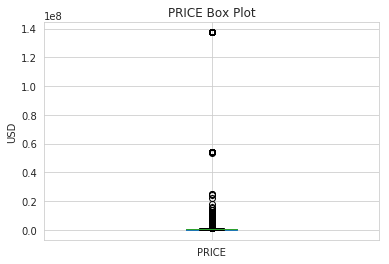

In [20]:
properties.PRICE.plot.box()
plt.ylabel("USD")
plt.title("PRICE Box Plot")

The cluster at 140 mil doesn't look right. The cluster at 60 mil doesn't look right either.<br> https://www.cnbc.com/2018/05/30/photos-of-the-most-expensive-home-for-sale-in-the-washington-dc-area.html

First cluster:

In [21]:
len(properties[properties.PRICE > 60000000])

242

In [22]:
properties[properties.PRICE > 60000000].PRICE.head()

125662    137427545.0
125663    137427545.0
125664    137427545.0
125670    137427545.0
125845    137427545.0
Name: PRICE, dtype: float64

In [23]:
sum(properties[properties.PRICE > 60000000].PRICE == 137427545)

242

Second cluster:

In [24]:
len(properties[(properties.PRICE > 50000000) & (properties.PRICE < 60000000)])

119

In [25]:
properties[(properties.PRICE > 50000000) & (properties.PRICE < 60000000)].PRICE.head()

132018    53969391.0
132019    53969391.0
132020    53969391.0
132021    53969391.0
132023    53969391.0
Name: PRICE, dtype: float64

In [26]:
sum(properties[(properties.PRICE > 50000000) & (properties.PRICE < 60000000)].PRICE == 53969391)

118

In [27]:
properties[(properties.PRICE > 50000000) & (properties.PRICE < 60000000)].loc[properties.PRICE != 53969391].PRICE

132028    53696391.0
Name: PRICE, dtype: float64

53,**969**,391 vs. 53,**696**,391..

It makes sense to get rid of these rows.

In [28]:
properties = properties[properties.PRICE < 50000000]
properties.shape

(97855, 48)

How cheap can DC houses go?<br>
Redfin shows a condo or two being sold under 50k. However, most of those "houses" being sold "for cheap" are garages. To be safe, we have decided to get rid of rows whose prices are less than 100k.

In [29]:
len(properties[properties.PRICE < 100000])

5681

In [30]:
properties = properties[properties.PRICE >= 100000]
properties.shape

(92174, 48)

PRICE's distribution:

In [31]:
properties.reset_index(inplace=True, drop=True)

Text(0.5, 1.0, 'PRICE Box Plot')

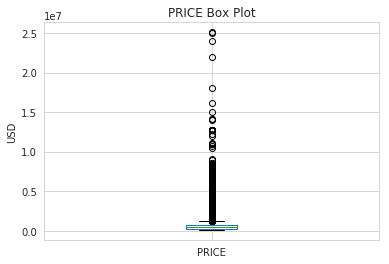

In [32]:
properties.PRICE.plot.box()
plt.ylabel("USD")
plt.title("PRICE Box Plot")

Text(0.5, 1.0, 'PRICE Histogram')

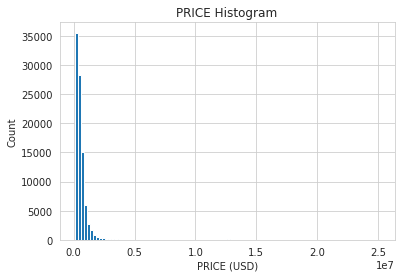

In [33]:
properties.PRICE.hist(bins=100)
plt.ylabel("Count")
plt.xlabel("PRICE (USD)")
plt.title("PRICE Histogram")

Would log be better?

In [34]:
properties["log(PRICE)"] = properties.PRICE.apply(lambda x: np.log(x))

Text(0.5, 1.0, 'log(PRICE) Histogram')

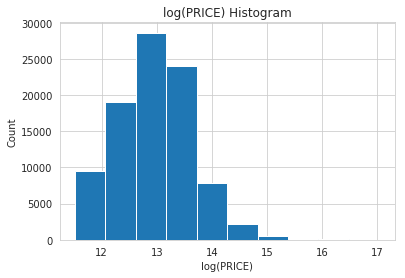

In [35]:
properties["log(PRICE)"].hist()
plt.ylabel("Count")
plt.xlabel("log(PRICE)")
plt.title("log(PRICE) Histogram")

Nice!

### GBA
Gross building area in square feet.

In [36]:
sum(properties.GBA.isna())

37433

In [37]:
print(str(round(sum(properties.GBA.isna()) / len(properties) * 100, 2)) + "% of our data is missing GBA values.")

40.61% of our data is missing GBA values.


Since we have a decent amount of data, we have decided to get rid of the rows that have missing values.

In [38]:
properties = properties[~properties.GBA.isna()]
properties.reset_index(inplace=True, drop=True)

GBA's distribution:

In [39]:
properties.GBA.describe()

count    54741.000000
mean      1747.658117
std        832.763023
min          0.000000
25%       1228.000000
50%       1522.000000
75%       2013.000000
max      15902.000000
Name: GBA, dtype: float64

Text(0, 0.5, 'Count')

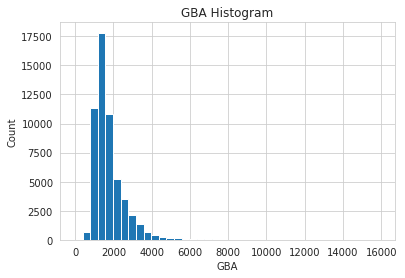

In [40]:
properties.GBA.hist(bins=40)
plt.title("GBA Histogram")
plt.xlabel("GBA")
plt.ylabel("Count")

### STYLE

In [41]:
sum(properties.STYLE.isna())

0

In [42]:
properties.STYLE.value_counts()

2 Story            41403
3 Story             5479
2.5 Story Fin       3885
1 Story             1823
1.5 Story Fin       1103
2.5 Story Unfin      373
4 Story              230
Split Level          157
Split Foyer          115
3.5 Story Fin         82
1.5 Story Unfin       51
Default               22
Bi-Level               8
3.5 Story Unfin        5
4.5 Story Unfin        2
Vacant                 2
4.5 Story Fin          1
Name: STYLE, dtype: int64

Dummy:

In [43]:
style_dummies = pd.get_dummies(properties.STYLE, prefix="STYLE", drop_first=True)
properties = pd.concat([properties, style_dummies], axis=1)
properties.drop("STYLE", axis=1, inplace=True)

### STRUCT

In [44]:
sum(properties.STRUCT.isna())

0

In [45]:
properties.STRUCT.value_counts()

Row Inside       22233
Single           15723
Semi-Detached     7472
Row End           6534
Multi             2514
Town Inside        182
Town End            76
Default              7
Name: STRUCT, dtype: int64

Dummy:

In [46]:
struct_dummies = pd.get_dummies(properties.STRUCT, prefix="STRUCT", drop_first=True)
properties = pd.concat([properties, struct_dummies], axis=1)
properties.drop("STRUCT", axis=1, inplace=True)

### GRADE

In [47]:
sum(properties.GRADE.isna())

0

In [48]:
properties.GRADE.value_counts()

Average          17499
Above Average    16527
Good Quality     11598
Very Good         4990
Excellent         1822
Superior          1519
Exceptional-A      472
Exceptional-B      168
Fair Quality        64
Exceptional-C       44
Exceptional-D       32
No Data              3
Low Quality          3
Name: GRADE, dtype: int64

It makes sense to get rid of No Data rows.

In [49]:
properties = properties[properties.GRADE != "No Data"]
properties.reset_index(inplace=True, drop=True)

Dummy:

In [50]:
grade_dummies = pd.get_dummies(properties.GRADE, prefix="GRADE", drop_first=True)
properties = pd.concat([properties, grade_dummies], axis=1)
properties.drop("GRADE", axis=1, inplace=True)

### CNDTN
Condition.

In [51]:
sum(properties.CNDTN.isna())

0

In [52]:
properties.CNDTN.value_counts()

Good         25271
Average      21422
Very Good     6653
Excellent      887
Fair           431
Poor            73
Default          1
Name: CNDTN, dtype: int64

Dummy:

In [53]:
cond_dummies = pd.get_dummies(properties.CNDTN, prefix="CNDTN", drop_first=True)
properties = pd.concat([properties, cond_dummies], axis=1)
properties.drop("CNDTN", axis=1, inplace=True)

### EXTWALL
Extrerior wall.

In [54]:
sum(properties.EXTWALL.isna())

0

In [55]:
properties.EXTWALL.value_counts()

Common Brick      40922
Brick/Siding       3405
Vinyl Siding       2941
Wood Siding        2155
Stucco             1584
Brick Veneer        562
Shingle             499
Face Brick          413
Aluminum            410
Brick/Stucco        393
Brick/Stone         380
Stone               363
Stone/Siding        207
Stone/Stucco        155
Stone Veneer        141
Hardboard            68
Concrete             38
Concrete Block       35
Metal Siding         27
Stucco Block         26
Default               9
Plywood               4
Adobe                 1
Name: EXTWALL, dtype: int64

Dummy:

In [56]:
exwa_dummies = pd.get_dummies(properties.EXTWALL, prefix="EXTWALL", drop_first=True)
properties = pd.concat([properties, exwa_dummies], axis=1)
properties.drop("EXTWALL", axis=1, inplace=True)

### ROOF
Roof type.

In [57]:
sum(properties.ROOF.isna())

0

In [58]:
properties.ROOF.value_counts()

Built Up          16335
Metal- Sms        15470
Comp Shingle      15325
Slate              5527
Neopren             897
Shake               351
Clay Tile           304
Shingle             225
Metal- Pre          122
Typical              83
Composition Ro       60
Metal- Cpr           19
Concrete Tile        11
Water Proof           4
Wood- FS              4
Concrete              1
Name: ROOF, dtype: int64

Dummy:

In [59]:
roof_dummies = pd.get_dummies(properties.ROOF, prefix="ROOF", drop_first=True)
properties = pd.concat([properties, roof_dummies], axis=1)
properties.drop("ROOF", axis=1, inplace=True)

### INTWALL
Interior wall.

In [60]:
sum(properties.INTWALL.isna())

0

In [61]:
properties.INTWALL.value_counts()

Hardwood         41836
Hardwood/Carp     7263
Wood Floor        3625
Carpet            1850
Lt Concrete         46
Ceramic Tile        37
Default             35
Vinyl Comp          18
Parquet             11
Vinyl Sheet          8
Resiliant            6
Terrazo              3
Name: INTWALL, dtype: int64

Dummy:

In [62]:
inwa_dummies = pd.get_dummies(properties.INTWALL, prefix="INTWALL", drop_first=True)
properties = pd.concat([properties, inwa_dummies], axis=1)
properties.drop("INTWALL", axis=1, inplace=True)

### BATHRM

In [63]:
sum(properties.BATHRM.isna())

0

In [64]:
properties.BATHRM.describe()

count    54738.000000
mean         2.242793
std          1.060817
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: BATHRM, dtype: float64

In [65]:
properties.BATHRM.value_counts()

2     20590
1     14509
3     13367
4      4972
5       845
6       303
7        81
8        33
0        16
9        11
10        7
11        3
12        1
Name: BATHRM, dtype: int64

It doesn't make sense to not have a bathroom.

In [66]:
properties = properties[properties.BATHRM > 0]
properties.reset_index(inplace=True, drop=True)

Dummy:

In [67]:
bath_dummies = pd.get_dummies(properties.BATHRM, prefix="BATHRM", drop_first=True)
properties = pd.concat([properties, bath_dummies], axis=1)
properties.drop("BATHRM", axis=1, inplace=True)

### HF_BATHRM

In [68]:
sum(properties.HF_BATHRM.isna())

0

In [69]:
properties.HF_BATHRM.describe()

count    54722.000000
mean         0.670334
std          0.606411
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: HF_BATHRM, dtype: float64

In [70]:
properties.HF_BATHRM.value_counts()

1     29542
0     21724
2      3284
3       136
4        26
5         7
7         2
11        1
Name: HF_BATHRM, dtype: int64

Dummy:

In [71]:
hf_bath_dummies = pd.get_dummies(properties.HF_BATHRM, prefix="HF_BATHRM", drop_first=True)
properties = pd.concat([properties, hf_bath_dummies], axis=1)
properties.drop("HF_BATHRM", axis=1, inplace=True)

### HEAT

In [72]:
sum(properties.HEAT.isna())

0

In [73]:
properties.HEAT.describe()

count          54722
unique            14
top       Forced Air
freq           21016
Name: HEAT, dtype: object

In [74]:
properties.HEAT.value_counts()

Forced Air        21016
Hot Water Rad     18944
Warm Cool         13614
Ht Pump             776
Water Base Brd       91
Wall Furnace         72
Elec Base Brd        65
Electric Rad         35
Air-Oil              35
Gravity Furnac       32
No Data              13
Air Exchng           12
Evp Cool             11
Ind Unit              6
Name: HEAT, dtype: int64

It makes sense to get rid of No Data rows.

In [75]:
properties = properties[properties.HEAT != "No Data"]
properties.reset_index(inplace=True, drop=True)

In [76]:
properties.shape

(54709, 146)

Dummy:

In [77]:
heat_dummies = pd.get_dummies(properties.HEAT, prefix="HEAT", drop_first=True)
properties = pd.concat([properties, heat_dummies], axis=1)
properties.drop("HEAT", axis=1, inplace=True)

### AC

In [78]:
sum(properties.AC.isna())

0

In [79]:
properties.AC.describe()

count     54709
unique        3
top           Y
freq      40979
Name: AC, dtype: object

In [80]:
properties.AC.value_counts()

Y    40979
N    13718
0       12
Name: AC, dtype: int64

It makes sense to get rid of 0 rows.

In [81]:
properties = properties[properties.AC != "0"]
properties.reset_index(inplace=True, drop=True)

Dummy:

In [82]:
ac_dummies = pd.get_dummies(properties.AC, prefix="AC", drop_first=True)
properties = pd.concat([properties, ac_dummies], axis=1)
properties.drop("AC", axis=1, inplace=True)

### NUM_UNITS

In [83]:
sum(properties.NUM_UNITS.isna())

0

In [84]:
properties.NUM_UNITS.describe()

count    54697.000000
mean         1.218586
std          0.617154
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: NUM_UNITS, dtype: float64

In [85]:
properties.NUM_UNITS.value_counts()

1.0    46624
2.0     5768
4.0     1694
3.0      558
0.0       45
5.0        5
6.0        3
Name: NUM_UNITS, dtype: int64

Dummy:

In [86]:
unit_dummies = pd.get_dummies(properties.NUM_UNITS, prefix="NUM_UNITS", drop_first=True)
properties = pd.concat([properties, unit_dummies], axis=1)
properties.drop("NUM_UNITS", axis=1, inplace=True)

### ROOMS

In [87]:
sum(properties.ROOMS.isna())

0

In [88]:
properties.ROOMS.describe()

count    54697.000000
mean         7.494652
std          2.295094
min          0.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         31.000000
Name: ROOMS, dtype: float64

In [89]:
properties.ROOMS.value_counts()

6     16998
7     10924
8      8854
5      4294
9      4083
10     3499
12     1685
11     1316
4      1062
16      731
13      417
14      305
15      165
3       103
20       75
18       65
17       34
2        20
0        20
19       16
21        8
24        6
23        5
22        4
25        3
28        2
30        1
26        1
31        1
Name: ROOMS, dtype: int64

It doesn't make sense to not have a room.

In [90]:
properties = properties[properties.ROOMS > 0]
properties.reset_index(inplace=True, drop=True)

Dummy:

In [91]:
rooms_dummies = pd.get_dummies(properties.ROOMS, prefix="ROOMS", drop_first=True)
properties = pd.concat([properties, rooms_dummies], axis=1)
properties.drop("ROOMS", axis=1, inplace=True)

### BEDRM

In [92]:
sum(properties.BEDRM.isna())

0

In [93]:
properties.BEDRM.describe()

count    54677.000000
mean         3.452347
std          1.112952
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         20.000000
Name: BEDRM, dtype: float64

In [94]:
properties.BEDRM.value_counts()

3     26099
4     13984
2      7398
5      4202
6      1826
7       441
8       432
1       172
9        52
10       22
0        19
12       18
11        8
15        1
13        1
14        1
20        1
Name: BEDRM, dtype: int64

Studios technically don't have a bedroom.

Dummy:

In [95]:
bed_rooms_dummies = pd.get_dummies(properties.BEDRM, prefix="BEDRM", drop_first=True)
properties = pd.concat([properties, bed_rooms_dummies], axis=1)
properties.drop("BEDRM", axis=1, inplace=True)

### AYB
The earliest time the main portion of the building was built.

In [96]:
sum(properties.AYB.isna())

81

In [97]:
properties.AYB.describe()

count    54596.000000
mean      1934.582863
std         31.002298
min       1754.000000
25%       1913.000000
50%       1928.000000
75%       1947.000000
max       2018.000000
Name: AYB, dtype: float64

It doesn't hurt to get rid of the rows with missing data.

In [98]:
properties = properties[~properties.AYB.isna()]
properties.reset_index(inplace=True, drop=True)

AYB's distribution:

Text(0, 0.5, 'Count')

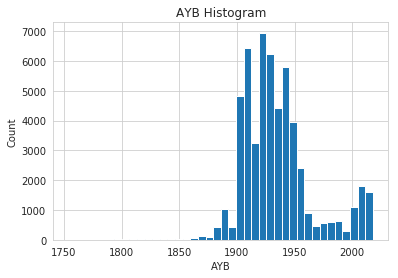

In [99]:
properties.AYB.hist(bins=40)
plt.title("AYB Histogram")
plt.xlabel("AYB")
plt.ylabel("Count")

### YR_RMDL
Year structure was remodeled.

In [100]:
sum(properties.YR_RMDL.isna())

22321

In [101]:
print(str(round(sum(properties.YR_RMDL.isna()) / len(properties) * 100, 2)) + "% of our data is missing YR_RMDL values.")

40.88% of our data is missing YR_RMDL values.


We have decided to get rid of this feature due to the large number of rows missing data.

In [102]:
properties.drop("YR_RMDL", axis=1, inplace=True)

### EYB
The year an improvement was built more recent than actual year built.

In [103]:
sum(properties.EYB.isna())

0

In [104]:
properties.EYB.describe()

count    54596.000000
mean      1970.493754
std         16.887684
min       1915.000000
25%       1960.000000
50%       1967.000000
75%       1976.000000
max       2018.000000
Name: EYB, dtype: float64

EYB's distribution:

Text(0, 0.5, 'Count')

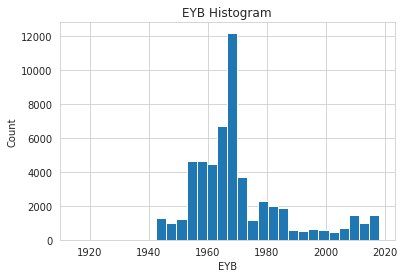

In [105]:
properties.EYB.hist(bins=30)
plt.title("EYB Histogram")
plt.xlabel("EYB")
plt.ylabel("Count")

### STORIES
Number of stories in primary dwelling.

In [106]:
sum(properties.STORIES.isna())

32

It makes sense to get rid of the rows with missing data.

In [107]:
properties = properties[~properties.STORIES.isna()]
properties.reset_index(inplace=True, drop=True)

In [108]:
properties.STORIES.describe()

count    54564.000000
mean         2.132690
std          4.064931
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        826.000000
Name: STORIES, dtype: float64

In [109]:
properties.STORIES.value_counts()

2.00      40327
3.00       5320
2.50       3328
1.00       1927
2.25       1275
1.50        955
1.75        576
2.75        264
4.00        234
1.25        199
3.50         61
2.70         14
3.25         14
3.75         10
9.00         10
0.00         10
5.00          9
2.20          8
6.00          5
25.00         4
2.30          3
1.70          3
275.00        2
3.70          1
8.25          1
0.25          1
20.00         1
250.00        1
826.00        1
Name: STORIES, dtype: int64

There's no way a building has more than 200 stories.<br>It makes sense to get rid of the rows whose stories are greater than 25.

In [110]:
properties = properties[~(properties.STORIES > 25)]
properties.reset_index(inplace=True, drop=True)

Dummy:

In [111]:
stories_dummies = pd.get_dummies(properties.STORIES, prefix="STORIES", drop_first=True)
properties = pd.concat([properties, stories_dummies], axis=1)
properties.drop("STORIES", axis=1, inplace=True)

### SALEDATE
Date of most recent sale.

In [112]:
sum(properties.SALEDATE.isna())

0

In [113]:
properties.SALEDATE.describe()

count                   54560
unique                   6305
top       2018-07-03 00:00:00
freq                       55
Name: SALEDATE, dtype: object

In [114]:
properties.SALEDATE.head()

0    2003-11-25 00:00:00
1    2016-06-21 00:00:00
2    2006-07-12 00:00:00
3    2010-02-26 00:00:00
4    2011-09-29 00:00:00
Name: SALEDATE, dtype: object

In [115]:
properties.SALEDATE = pd.to_datetime(properties.SALEDATE, format="%Y/%m/%d")

SALEDATE's distribution:

Text(0, 0.5, 'Count')

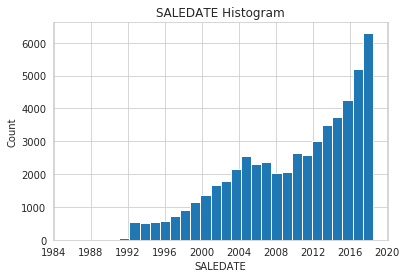

In [116]:
properties.SALEDATE.hist(bins=30)
plt.title("SALEDATE Histogram")
plt.xlabel("SALEDATE")
plt.ylabel("Count")

### QUALIFIED

In [117]:
sum(properties.QUALIFIED.isna())

0

In [118]:
properties.QUALIFIED.describe()

count     54560
unique        2
top           Q
freq      44336
Name: QUALIFIED, dtype: object

In [119]:
properties.QUALIFIED.value_counts()

Q    44336
U    10224
Name: QUALIFIED, dtype: int64

Dummy:

In [120]:
qualified_dummies = pd.get_dummies(properties.QUALIFIED, prefix="QUALIFIED", drop_first=True)
properties = pd.concat([properties, qualified_dummies], axis=1)
properties.drop("QUALIFIED", axis=1, inplace=True)

### SALE_NUM

In [121]:
sum(properties.SALE_NUM.isna())

0

In [122]:
properties.SALE_NUM.describe()

count    54560.000000
mean         1.898864
std          1.479083
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         15.000000
Name: SALE_NUM, dtype: float64

In [123]:
properties.SALE_NUM.value_counts()

1     35474
3      6265
4      4517
2      4398
5      2195
6      1013
7       401
8       166
9        80
10       26
11       12
12        6
13        3
15        2
14        2
Name: SALE_NUM, dtype: int64

Dummy:

In [124]:
sale_dummies = pd.get_dummies(properties.SALE_NUM, prefix="SALE_NUM", drop_first=True)
properties = pd.concat([properties, sale_dummies], axis=1)
properties.drop("SALE_NUM", axis=1, inplace=True)

### BLDG_NUM
Building Number on Property.

In [125]:
sum(properties.BLDG_NUM.isna())

0

In [126]:
properties.BLDG_NUM.value_counts()

1    54548
2       12
Name: BLDG_NUM, dtype: int64

In [127]:
properties.BLDG_NUM.value_counts(normalize=True)

1    0.99978
2    0.00022
Name: BLDG_NUM, dtype: float64

Dummy:

In [128]:
bldg_num_dummies = pd.get_dummies(properties.BLDG_NUM, prefix="BLDG_NUM", drop_first=True)
properties = pd.concat([properties, bldg_num_dummies], axis=1)
properties.drop("BLDG_NUM", axis=1, inplace=True)

### KITCHENS

In [129]:
sum(properties.KITCHENS.isna())

1

It makes sense to get rid of the row with missing data.

In [130]:
properties = properties[~properties.KITCHENS.isna()]
properties.reset_index(inplace=True, drop=True)

In [131]:
properties.KITCHENS.describe()

count    54559.000000
mean         1.250719
std          0.657439
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         44.000000
Name: KITCHENS, dtype: float64

In [132]:
properties.KITCHENS.value_counts()

1.0     44884
2.0      7353
4.0      1693
3.0       596
0.0        24
6.0         4
5.0         4
44.0        1
Name: KITCHENS, dtype: int64

It doesn't make sense to not have a kitchen.<br>It doesn't make sense to have 44 kitchens.

In [133]:
properties = properties[properties.KITCHENS != 0]
properties = properties[properties.KITCHENS != 44]
properties.reset_index(inplace=True, drop=True)

KITCHENS' distribution:

Dummy:

In [134]:
kitchens_dummies = pd.get_dummies(properties.KITCHENS, prefix="KITCHENS", drop_first=True)
properties = pd.concat([properties, kitchens_dummies], axis=1)
properties.drop("KITCHENS", axis=1, inplace=True)

### FIREPLACES

In [135]:
sum(properties.FIREPLACES.isna())

0

In [136]:
properties.FIREPLACES.describe()

count    54534.000000
mean         0.671526
std          0.921298
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         13.000000
Name: FIREPLACES, dtype: float64

In [137]:
properties.FIREPLACES.value_counts()

0     29400
1     17075
2      5908
3      1388
4       471
5       162
6        85
7        26
8         8
9         4
13        2
11        2
10        2
12        1
Name: FIREPLACES, dtype: int64

Dummy:

In [138]:
fireplaces_dummies = pd.get_dummies(properties.FIREPLACES, prefix="FIREPLACES", drop_first=True)
properties = pd.concat([properties, fireplaces_dummies], axis=1)
properties.drop("FIREPLACES", axis=1, inplace=True)

### USECODE
Property use code.

In [139]:
sum(properties.USECODE.isna())

0

In [140]:
properties.USECODE.describe()

count    54534.000000
mean        13.269850
std          4.181479
min         11.000000
25%         11.000000
50%         12.000000
75%         13.000000
max         39.000000
Name: USECODE, dtype: float64

In [141]:
properties.USECODE.value_counts()

11    24403
12    15397
13     7322
24     5039
23     2338
15       30
19        4
39        1
Name: USECODE, dtype: int64

Dummy:

In [142]:
usecode_dummies = pd.get_dummies(properties.USECODE, prefix="USECODE", drop_first=True)
properties = pd.concat([properties, usecode_dummies], axis=1)
properties.drop("USECODE", axis=1, inplace=True)

### LANDAREA
Land area of property in square feet.

In [143]:
sum(properties.LANDAREA.isna())

0

In [144]:
properties.LANDAREA.describe()

count     54534.000000
mean       3204.603165
std        3096.421435
min           0.000000
25%        1520.000000
50%        2229.000000
75%        4000.000000
max      155905.000000
Name: LANDAREA, dtype: float64

LANDAREA's distribution:

Text(0, 0.5, 'Count')

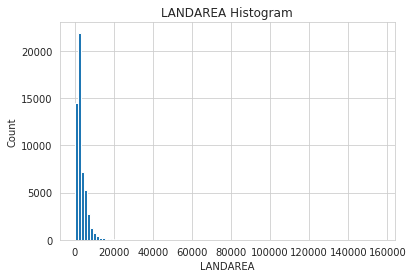

In [145]:
properties.LANDAREA.hist(bins=100)
plt.title("LANDAREA Histogram")
plt.xlabel("LANDAREA")
plt.ylabel("Count")

### GIS_LAST_MOD_DTTM
Last Modified Date.

In [146]:
sum(properties.GIS_LAST_MOD_DTTM.isna())

0

In [147]:
properties.GIS_LAST_MOD_DTTM.describe()

count                   54534
unique                      1
top       2018-07-22 18:01:43
freq                    54534
Name: GIS_LAST_MOD_DTTM, dtype: object

We don't think this feature will be useful at all.

In [148]:
properties.drop("GIS_LAST_MOD_DTTM", axis=1, inplace=True)

### SOURCE
Raw Data Source.

In [149]:
sum(properties.SOURCE.isna())

0

In [150]:
properties.SOURCE.describe()

count           54534
unique              1
top       Residential
freq            54534
Name: SOURCE, dtype: object

We don't think this feature will be useful at all.

In [151]:
properties.drop("SOURCE", axis=1, inplace=True)

### CMPLX_NUM
Complex number.

In [152]:
sum(properties.CMPLX_NUM.isna())

54534

In [153]:
properties.CMPLX_NUM.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: CMPLX_NUM, dtype: float64

We don't think this feature will be useful at all.

In [154]:
properties.drop("CMPLX_NUM", axis=1, inplace=True)

### LIVING_GBA
Gross building area in square feet.

In [155]:
sum(properties.LIVING_GBA.isna())

54534

In [156]:
properties.LIVING_GBA.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: LIVING_GBA, dtype: float64

We don't think this feature will be useful at all.

In [157]:
properties.drop("LIVING_GBA", axis=1, inplace=True)

### FULLADDRESS
Full Street Address.

In [158]:
sum(properties.FULLADDRESS.isna())

310

In [159]:
properties.FULLADDRESS.describe()

count                  54224
unique                 54213
top       131 11TH STREET SE
freq                       2
Name: FULLADDRESS, dtype: object

In [160]:
properties.FULLADDRESS.value_counts().head()

131 11TH STREET SE     2
1800 11TH STREET NW    2
3327 P STREET NW       2
945 O STREET NW        2
900 55TH STREET NE     2
Name: FULLADDRESS, dtype: int64

We don't think this feature will be useful at all.

In [161]:
properties.drop("FULLADDRESS", axis=1, inplace=True)

### CITY

In [162]:
sum(properties.CITY.isna())

306

In [163]:
properties.CITY.describe()

count          54228
unique             1
top       WASHINGTON
freq           54228
Name: CITY, dtype: object

We don't think this feature will be useful at all.

In [164]:
properties.drop("CITY", axis=1, inplace=True)

### STATE

In [165]:
sum(properties.STATE.isna())

306

In [166]:
properties.STATE.describe()

count     54228
unique        1
top          DC
freq      54228
Name: STATE, dtype: object

We don't think this feature will be useful at all.

In [167]:
properties.drop("STATE", axis=1, inplace=True)

### ZIPCODE

In [168]:
sum(properties.ZIPCODE.isna())

0

In [169]:
properties.ZIPCODE.describe()

count    54534.000000
mean     20011.500678
std          7.599215
min      20001.000000
25%      20003.000000
50%      20011.000000
75%      20017.000000
max      20052.000000
Name: ZIPCODE, dtype: float64

In [170]:
properties.ZIPCODE.value_counts()

20002.0    7442
20011.0    7228
20019.0    5255
20003.0    3689
20016.0    3605
20007.0    3525
20020.0    3364
20001.0    2987
20015.0    2601
20018.0    2516
20010.0    2263
20017.0    2182
20009.0    1912
20008.0    1836
20012.0    1716
20032.0    1685
20024.0     311
20037.0     197
20005.0     128
20036.0      85
20052.0       7
Name: ZIPCODE, dtype: int64

Dummy:

In [171]:
zip_dummies = pd.get_dummies(properties.ZIPCODE, prefix="ZIPCODE", drop_first=True)
properties = pd.concat([properties, zip_dummies], axis=1)
properties.drop("ZIPCODE", axis=1, inplace=True)

### NATIONALGRID
Address location national grid coordinate spatial address.

In [172]:
sum(properties.NATIONALGRID.isna())

306

In [173]:
properties.NATIONALGRID.describe()

count                  54228
unique                 54205
top       18S UJ 26617 07043
freq                       2
Name: NATIONALGRID, dtype: object

In [174]:
properties.NATIONALGRID.value_counts().head()

18S UJ 26617 07043    2
18S UJ 28001 06126    2
18S UJ 19103 10982    2
18S UJ 25398 04622    2
18S UJ 21573 08625    2
Name: NATIONALGRID, dtype: int64

We don't think this feature will be useful at all.

In [175]:
properties.drop("NATIONALGRID", axis=1, inplace=True)

### LATITUDE

In [176]:
sum(properties.LATITUDE.isna())

0

In [177]:
properties.LATITUDE.describe()

count    54534.000000
mean        38.917034
std          0.033505
min         38.820060
25%         38.893773
50%         38.917392
75%         38.943362
max         38.995435
Name: LATITUDE, dtype: float64

LATITUDE's distribution:

Text(0, 0.5, 'Count')

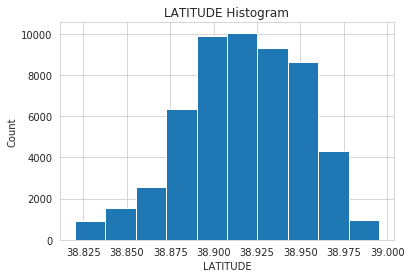

In [178]:
properties.LATITUDE.hist()
plt.title("LATITUDE Histogram")
plt.xlabel("LATITUDE")
plt.ylabel("Count")

### LONGITUDE

In [179]:
sum(properties.LONGITUDE.isna())

0

In [180]:
properties.LONGITUDE.describe()

count    54534.000000
mean       -77.012033
std          0.043154
min        -77.113909
25%        -77.038538
50%        -77.009369
75%        -76.984581
max        -76.909758
Name: LONGITUDE, dtype: float64

LONGITUDE's distribution:

Text(0, 0.5, 'Count')

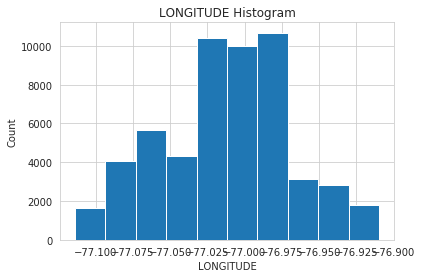

In [181]:
properties.LONGITUDE.hist()
plt.title("LONGITUDE Histogram")
plt.xlabel("LONGITUDE")
plt.ylabel("Count")

### ASSESSMENT_NBHD
Neighborhood ID.

In [182]:
sum(properties.ASSESSMENT_NBHD.isna())

0

In [183]:
properties.ASSESSMENT_NBHD.describe()

count          54534
unique            55
top       Old City 1
freq            7038
Name: ASSESSMENT_NBHD, dtype: object

In [184]:
properties.ASSESSMENT_NBHD.value_counts()

Old City 1                      7038
Petworth                        2807
Columbia Heights                2795
Old City 2                      2710
Chevy Chase                     2631
Deanwood                        2593
Brookland                       2514
Brightwood                      1786
Capitol Hill                    1714
Congress Heights                1568
Georgetown                      1467
Randle Heights                  1437
Fort Dupont Park                1370
Trinidad                        1368
American University             1246
Woodridge                       1243
Riggs Park                      1143
Hillcrest                       1090
16th Street Heights             1022
Eckington                        971
Mt. Pleasant                     910
Ledroit Park                     783
Anacostia                        715
Marshall Heights                 714
Lily Ponds                       663
Fort Lincoln                     561
Cleveland Park                   549
S

Dummy:

In [185]:
neighborhood_dummies = pd.get_dummies(properties.ASSESSMENT_NBHD, prefix="ASSESSMENT_NBHD", drop_first=True)
properties = pd.concat([properties, neighborhood_dummies], axis=1)
properties.drop("ASSESSMENT_NBHD", axis=1, inplace=True)

### ASSESSMENT_SUBNBHD
Subneighborhood ID.

In [186]:
sum(properties.ASSESSMENT_SUBNBHD.isna())

7839

In [187]:
properties.ASSESSMENT_SUBNBHD.describe()

count                46695
unique                 121
top       039 K Old City 1
freq                  1318
Name: ASSESSMENT_SUBNBHD, dtype: object

Since this feature is basically a more detailed version of ASSESSMENT_NBHD, we have decided not to use it.<br>The main reason is its lack of data!

In [188]:
properties.drop("ASSESSMENT_SUBNBHD", axis=1, inplace=True)

### WARD

In [189]:
sum(properties.WARD.isna())

0

In [190]:
properties.WARD.describe()

count      54534
unique         8
top       Ward 4
freq       10073
Name: WARD, dtype: object

In [191]:
properties.WARD.value_counts()

Ward 4    10073
Ward 6     9209
Ward 5     8975
Ward 3     7874
Ward 7     6773
Ward 1     4397
Ward 8     3863
Ward 2     3370
Name: WARD, dtype: int64

Dummy:

In [192]:
ward_dummies = pd.get_dummies(properties.WARD, prefix="WARD", drop_first=True)
properties = pd.concat([properties, ward_dummies], axis=1)
properties.drop("WARD", axis=1, inplace=True)

### QUADRANT

In [193]:
sum(properties.QUADRANT.isna())

99

It makes sense to get rid of the rows with missing data.

In [194]:
properties = properties[~properties.QUADRANT.isna()]
properties.reset_index(inplace=True, drop=True)

In [195]:
properties.QUADRANT.describe()

count     54435
unique        4
top          NW
freq      26787
Name: QUADRANT, dtype: object

Dummy:

In [196]:
quad_dummies = pd.get_dummies(properties.QUADRANT, prefix="QUADRANT", drop_first=True)
properties = pd.concat([properties, quad_dummies], axis=1)
properties.drop("QUADRANT", axis=1, inplace=True)

### CENSUS_TRACT, CENSUS_BLOCK, SQUARE, X, and Y

We have decided not to use these features for this project due to our lack of knowledge about them. That said, we will consider them for our future work.

In [197]:
properties.drop(["CENSUS_TRACT", "CENSUS_BLOCK", "SQUARE", "X", "Y"], axis=1, inplace=True)

## Processed data

In [198]:
properties.shape

(54435, 327)

Change directory to save data:

In [199]:
cd = change_directory.ChangeDirectory()
cd.change_to_data_dir()

Save data:

In [200]:
properties.to_csv("processed/Processed_DC_Properties.csv", index=False)

Change back to notebook directory:

In [201]:
cd.change_to_notebook_dir()